In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Model dyskryminatora

In [2]:
class Discriminator(nn.Module):

    def __init__(self, input_picture_size: int) -> None:
        super().__init__()

        assert input_picture_size in [32, 64], "Input picture size can be only 32 or 64"

        self.model = nn.Sequential(

            nn.Conv2d(3, 32, (4, 4), stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, (4, 4), stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, (4, 4), stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Dropout1d(0.2),
            nn.Linear(input_picture_size**2, 1),
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.model(x)

### Model generatora

In [3]:
from typing import Optional
from abc import ABC


class BaseGenerator(ABC):

    def generate(self, noise_vectors: torch.Tensor) -> torch.Tensor:
        self.eval()
        with torch.no_grad():
            out_images = self(noise_vectors)
        return out_images
    
    def _get_device(self) -> str:
        return next(self.parameters()).device

    def generate_training_examples(self, batch_size: int, device: Optional[str] = None) -> torch.Tensor:
        self.train()
        if device is None:
            device = self._get_device()
        random_vectors = torch.randn(batch_size, self.input_size).to(device)
        return self(random_vectors)
    

class Generator(nn.Module, BaseGenerator):

    def __init__(self, input_vector_size: int) -> None:
        super().__init__()

        assert input_vector_size in [64, 128], "Input size can be only 64 or 128"

        self.input_size = input_vector_size

        start_size = 4 if input_vector_size == 64 else 8
        scale = 1 if input_vector_size == 64 else 2

        self.model = nn.Sequential(
            nn.Linear(input_vector_size, 64*scale*start_size*start_size),
            nn.Unflatten(-1, (scale*64, start_size, start_size)),

            nn.ConvTranspose2d(scale*64, scale*64, (4, 4), stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(scale*64, scale*128, (4, 4), stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(scale*128, scale*256, (4, 4), stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(scale*256, 3, (5, 5), padding=2),
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)        

### Model alternatywnego generatora

In [4]:
class AltGenerator(nn.Module, BaseGenerator):

    def __init__(self, input_vector_size: int):
        super().__init__()

        assert input_vector_size in [64, 128], "Input size can be only 64 or 128"

        self.input_size = input_vector_size

        start_size = 4 if input_vector_size == 64 else 8

        self.model = nn.Sequential(
            nn.Linear(input_vector_size, 32*start_size*start_size),
            nn.Unflatten(-1, (32, start_size, start_size)),

            self.upsampling_block(32, 32),
            self.upsampling_block(32, 64),
            self.upsampling_block(64, 128),

            nn.Conv2d(128, 3, (5, 5), padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)
    

    def upsampling_block(self, in_channels: int, out_channels: int):
        return nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),

            nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),

            nn.Conv2d(out_channels, out_channels, (3, 3), padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

In [5]:
import torchvision

def unnormalize(image): # The images pixel values are in range (-1, 1), bacause of normalization or tanh activation
    return image*0.5 + 0.5

def show_single_image(img: torch.tensor):
    assert 2 <= len(img.shape) <= 4, "Expected 2D, 3D or 4D(batched) image"

    if len(img.shape) == 4:
        img = img[0].permute(1, 2, 0)
    elif len(img.shape) == 3:
        img = img.permute(1, 2, 0)

    plt.imshow(unnormalize(img).to("cpu"), interpolation="bilinear")
    plt.axis('off')
    plt.show()

def show_image_batch(img_batch: torch.tensor, img_per_row: int = 4):
    grid = torchvision.utils.make_grid(img_batch.to("cpu"), img_per_row, scale_each=True)
    show_single_image(grid)

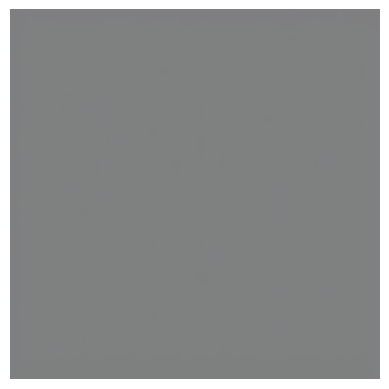

In [6]:
gen = Generator(64)
example = gen.generate(torch.randn(1, 64))
show_single_image(example)

In [7]:
# Funkcja do wybieranie urządzenia na którym odbędzie się trening
def choose_device():
    if torch.cuda.is_available():
        return "cuda"
    if torch.backends.mps.is_available():
        return "mps"
    return "cpu"

device = choose_device()
device

'mps'

### Przygotowanie datasetu

W klasie dataset znajduje się funkcja, która od razu wczytuje przykłady treningowe do pamięci urządzenia na którym będzie odbywał się trening. Znacząco przyśpiesza to trening, a wszystkie zdjęcia nie zajmują za dużo pamięci.

In [8]:
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
    

class InMemoryDataset(Dataset):

    def __init__(
            self, 
            data_path: str, 
            target_size: int,
            device: str,
            base_transforms: v2.Compose
        ):
        
        super().__init__()

        self.device = device
        self.data_path = data_path
        self.base_transforms = base_transforms
        
        self.images = self._read_all_images()


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        return self.images[idx]
    

    def _read_all_images(self):
        all = []
        for image in os.listdir(self.data_path):
            img = Image.open(f"{self.data_path}/{image}")
            img = self.base_transforms(img)
            all.append(img.to(self.device))
            
        return all

In [9]:
tf = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((32, 32)),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = InMemoryDataset(data_path="./data/crawled_cakes", device=device, target_size=32, base_transforms=tf)
dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0007584691..1.0000004].


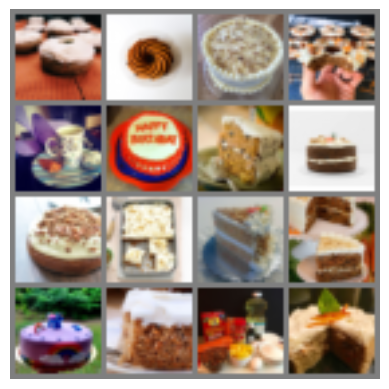

In [10]:
from itertools import islice

cakes = torch.stack(list(islice(dataset, 16)))
show_image_batch(cakes, img_per_row=4)

### GAN

Klasa GAN implementuje metodę batch_step, która wykonuje jeden krok epoki i zwraca wartość straty dla danego batcha. Ponadto klasa implementuje metody do zapisywania i wczytywania stanu modelu.

In [11]:
from torch.optim.optimizer import Optimizer
from torch.nn.modules.loss import _Loss
from torch.nn import BCEWithLogitsLoss
from typing import Type
from torch.optim import Adam
import os


def create_generator(generator_type: str, input_vector_size: int):
    assert generator_type in ["regular", "alternative"], "There are two possible generator architectures ['regular', 'alternative']"
    if generator_type == "regular":
        return Generator(input_vector_size)
    else:
        return AltGenerator(input_vector_size)


def generate_labels(size: int, offset: float = 0.0, noise_std: float = 0.05) -> torch.tensor:
    labels = (torch.zeros(size) + offset) + torch.normal(0, noise_std, (size, ))
    labels = labels.reshape(-1, 1)
    return labels

class GAN:

    def __init__(
        self,
        device: str,
        input_vector_size: int,
        optimizer: Type[Optimizer],
        criterion: Type[_Loss],

        generator_type: str,
        discriminator_lr: float,
        generator_lr: float,
        l2: float,
    ):
        
        self.device = device
        self.input_size = input_vector_size

        self.generator = create_generator(generator_type, input_vector_size)
        self.generator.to(device)
        
        self.discriminator = Discriminator(input_vector_size // 2).to(device)

        self.gen_optimizer = optimizer(self.generator.parameters(), lr=generator_lr)
        self.dis_optimizer = optimizer(self.discriminator.parameters(), lr=discriminator_lr, weight_decay=l2)

        self.criterion = criterion()


    def save_state(self, experiment_id: str, version: int):
        dir_path = f"./cached_models/{experiment_id}"
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)

        model_path = f"{dir_path}/model_{version}"
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        
        torch.save(self.generator.state_dict(), f"{model_path}/gen")
        torch.save(self.discriminator.state_dict(), f"{model_path}/dis")
        torch.save(self.gen_optimizer.state_dict(), f"{model_path}/gen_optim")
        torch.save(self.dis_optimizer.state_dict(), f"{model_path}/dis_optim")


    def load_state(self, experiment_id: str, version: int):
        dir_path = f"./cached_models/{experiment_id}" 
        model_path = f"{dir_path}/model_{version}"
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model {model_path} does not exists")

        self.generator.load_state_dict(torch.load(f"{model_path}/gen", weights_only=True))
        self.discriminator.load_state_dict(torch.load(f"{model_path}/dis", weights_only=True))
        self.gen_optimizer.load_state_dict(torch.load(f"{model_path}/gen_optim", weights_only=True))
        self.dis_optimizer.load_state_dict(torch.load(f"{model_path}/dis_optim", weights_only=True))
        

    def batch_step(self, batch: torch.tensor) -> tuple[float, float]:

        batch_size = len(batch)

        ## Discriminator step
        self.dis_optimizer.zero_grad()

        # Real images
        labels_1 = generate_labels(len(batch), 1.0, 0.05).to(self.device)
        pred_labels = self.discriminator(batch)
        loss_real = self.criterion(pred_labels, labels_1)

        # Fake images
        with torch.no_grad():
            random_batch = self.generator.generate_training_examples(batch_size, self.device)

        labels_0 = generate_labels(batch_size, 0.0, 0.05).to(self.device)
        pred_labels = self.discriminator(random_batch)
        loss_fake = self.criterion(pred_labels, labels_0)

        # Combine loss and update discriminator weights

        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        self.dis_optimizer.step()

        ## Generator step

        self.gen_optimizer.zero_grad()

        # Generate fake examples and labels
        random_batch = self.generator.generate_training_examples(batch_size, self.device)
        labels_1 = generate_labels(batch_size, 1.0, 0.0).to(self.device)
        pred_labels = self.discriminator(random_batch)

        # Update generator weights
        loss_gen = self.criterion(pred_labels, labels_1)
        loss_gen.backward()
        self.gen_optimizer.step()

        return loss_dis.item(), loss_gen.item()



### Trening Gana

In [12]:
def gan_training(
    experiment_id: str,
    dataset: InMemoryDataset,
    batch_size: int,
    device: str,

    max_epochs: int = 3000,
    loss_logging_step: int = 10,
    image_print_step: int = 50,
    model_checkpoint_step: int = 100,
    num_workers: int = 0,
    
    input_vector_size: int = 64,
    optimizer: Type[Optimizer] = Adam,
    criterion: Type[_Loss] = BCEWithLogitsLoss,
    generator_type: str = "regular",
    discriminator_lr: float = 0.00001,
    generator_lr: float = 0.000015,
    l2: float = 0.001,
):
    
    gan = GAN(
        device=device,
        input_vector_size=input_vector_size,
        optimizer=optimizer,
        criterion=criterion,
        generator_type=generator_type,
        discriminator_lr=discriminator_lr,
        generator_lr=generator_lr,
        l2=l2
    )
    
    validation_vectors = torch.randn(25, input_vector_size).to(device)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    loss_gen: dict[int, list[float]] = {}
    loss_dis: dict[int, list[float]] = {}

    for i in range(max_epochs):

        dis_running_loss = 0.0
        gen_running_loss = 0.0
        batch_count = 0

        for batch in data_loader:
            loss_dis, loss_gen = gan.batch_step(batch)

            dis_running_loss += loss_dis
            gen_running_loss += loss_gen
            batch_count += 1

        if (i + 1) % loss_logging_step == 0:
            print(f"Epoch {i + 1}")
            print(f"Discriminator loss: {(dis_running_loss / batch_count):.4f}")
            print(f"Generator loss: {(gen_running_loss / batch_count):.4f}")
            print()

        if (i + 1) % image_print_step == 0:
            with torch.no_grad():
                validation_images = gan.generator.generate(validation_vectors)
            show_image_batch(validation_images, img_per_row=5)

        if (i + 1) % model_checkpoint_step == 0:
            gan.save_state(experiment_id, i + 1)
    

In [ ]:
gan_training("trial_0", dataset, 16, device)

In [15]:
from torchvision.transforms.functional import to_pil_image
from functools import reduce
from typing import Callable

def compose2(f, g):
    return lambda x: f(g(x))

def compose(*fs):
    return reduce(compose2, fs)


def create_gif(
    tensor_mapping: Callable[[torch.Tensor], torch.Tensor], 
    vectors: list[torch.Tensor], 
    output_path: str,
) -> None:

    mapping = compose(
        to_pil_image,
        v2.Resize((356, 356), interpolation = v2.InterpolationMode.BILINEAR),
        unnormalize,
        torch.squeeze,
        tensor_mapping
    )
    
    images = list(map(mapping, vectors))
        
    images[0].save(
        output_path,
        save_all=True,
        append_images=images[1:],
        duration=[300] + [100 for _ in range(len(images) - 2)] + [500],
        loop=0
    )

In [27]:
# Wczytywanie wag samego generatora
def load_generator(experiment_id: str, version: int, input_size: int, generator_type: str = "regular"):
    model_path = f"./cached_models/{experiment_id}/model_{version}"
    weights_path = f"{model_path}/gen"

    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"File {weights_path} does not exists")
    
    gen = create_generator(generator_type, input_size)
    gen.load_state_dict(torch.load(f"{model_path}/gen", weights_only=True))
    return gen


def create_learning_progress_gif(experiment_id: str, input_size: int, output_path: str, generator_type: str = "regular"):
    model_path = f"./cached_models/{experiment_id}"
    model_versions = sorted(map(lambda x: int(x.split("_")[1]), os.listdir(model_path)))

    images = []
    vec = torch.randn(25, input_size)
    for version in model_versions:
        m = load_generator(experiment_id, version, input_size, generator_type)
        image_batch = m.generate(vec)
        images.append(torchvision.utils.make_grid(image_batch, nrow=5))

    create_gif(lambda x: x, images, output_path)

create_learning_progress_gif("trial_1", 64, "./gifs/trail_1_progress.gif")

![](./gifs/trail_1_progress.gif "learning_progress")

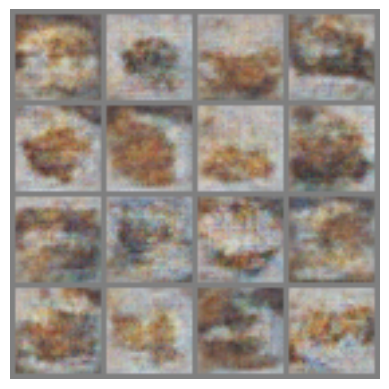

In [17]:
gen = load_generator("trial_4", 1100, 64)

with torch.no_grad():
    vec = torch.randn(16, 64)
    out = gen(vec)

show_image_batch(out, 4)

In [18]:
from torch.optim import SGD
from copy import deepcopy

def find_optimal_vector(
        model: Generator, 
        target_picture: torch.Tensor,
        input_size: int
    ) -> list[torch.Tensor]:
    
    initial_vector = torch.randn((1, input_size), requires_grad=True)
    optimizer = SGD([initial_vector], lr=0.01, momentum=0.9)
    frames = []

    for i in range(200):
        optimizer.zero_grad()
        out_vector = model(initial_vector)
        
        frames.append(deepcopy(initial_vector.detach()))

        loss = (out_vector - target_picture).square().sum()
        loss.backward()
        optimizer.step()

    model.zero_grad()
    return frames


def find_best_initial_vector(model: Generator, target_picture: torch.Tensor, input_size: int, save_gif: Optional[str] = None, image_step: int = 1) -> torch.Tensor:
    show_single_image(target_picture)
    intermediate_vectors = find_optimal_vector(model, target_picture, input_size)

    print("Model Generated: ")
    final_vector = intermediate_vectors[-1]
    show_single_image(model.generate(final_vector))

    if save_gif:
        intermediate_vectors = intermediate_vectors[::image_step]
        create_gif(gen, intermediate_vectors, save_gif)
    
    return final_vector


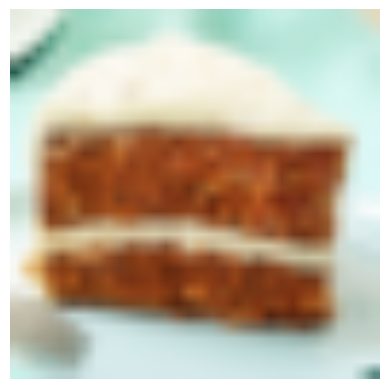

Model Generated: 


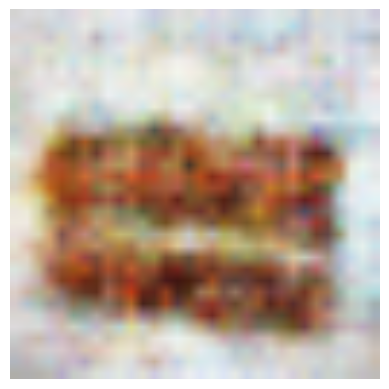

In [19]:
random_picture = dataset[52].to("cpu").unsqueeze(0)
best_init_vec_1 = find_best_initial_vector(gen, random_picture, 64, "./gifs/search.gif", image_step=5)

![](./gifs/search.gif "search")

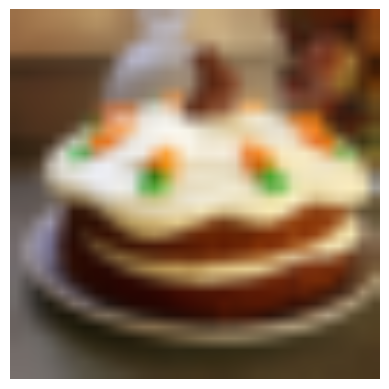

Model Generated: 


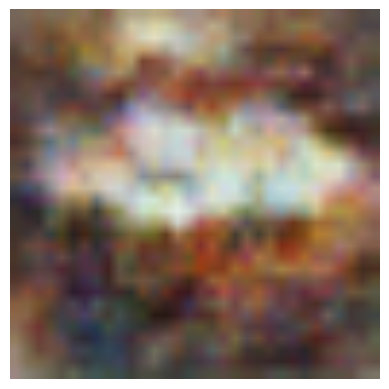

In [20]:
random_picture = dataset[60].to("cpu").unsqueeze(0)
best_init_vec_2 = find_best_initial_vector(gen, random_picture, 64)

In [21]:
steps = 30
dir = (best_init_vec_2 - best_init_vec_1) / steps
values = [best_init_vec_1 + i*dir for i in range(steps + 1)]
create_gif(gen, values, "./gifs/transition.gif")

![](./gifs/transition.gif "transition")

### Data Augmentation

In [22]:
from random import randrange

class AugmentedDataset(Dataset):

    def __init__(self, base_dataset: Dataset, augmenting_transforms: list[v2.Transform]) -> None:
        super().__init__()
        
        self.base_dataset = base_dataset
        self.transforms = augmenting_transforms
        self.count_transforms = len(self.transforms)


    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        element = self.base_dataset[idx]
        if (choice := randrange(self.count_transforms*2)) < self.count_transforms:
            return self.transforms[choice](element)
        return element

base_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((64, 64)),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augment_transforms = [
    v2.RandomHorizontalFlip(1.0),
    v2.RandomRotation((-15, 15), interpolation=v2.InterpolationMode.BILINEAR),
    v2.RandomAffine((-15, 15)),
    v2.RandomResizedCrop((64, 64), interpolation=v2.InterpolationMode.NEAREST),
]

bigger_dataset = InMemoryDataset("./data/crawled_cakes", 64, device, base_transforms=base_transforms)
augmented_dataset = AugmentedDataset(bigger_dataset, augment_transforms)
augmented_dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


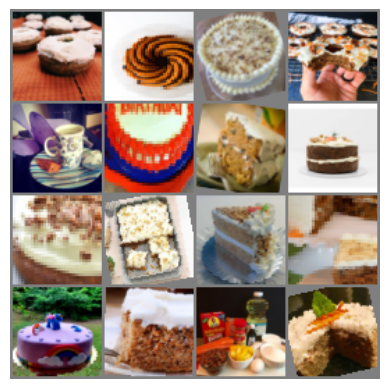

In [23]:
from itertools import islice

cakes = torch.stack(list(islice(augmented_dataset, 16)))
show_image_batch(cakes, img_per_row=4)

In [ ]:
gan_training(
    experiment_id="augmentation",
    dataset=augmented_dataset,
    batch_size=16,
    device=device,
    max_epochs=3000,
    input_vector_size=128,
    generator_type="alternative"
)

In [28]:
create_learning_progress_gif("augmentation", 128, "./gifs/augmentation_progress.gif", "alternative")

![](./gifs/augmentation_progress.gif "augmentation")

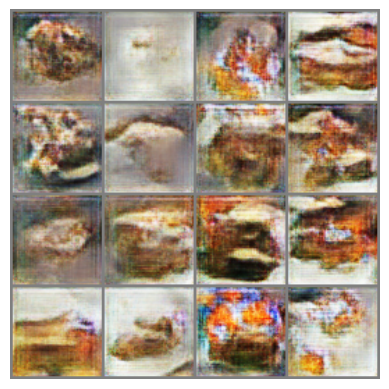

In [44]:
gen = load_generator("augmentation", 1000, 128, "alternative")

with torch.no_grad():
    vec = torch.randn(16, 128)
    out = gen(vec)

show_image_batch(out, 4)

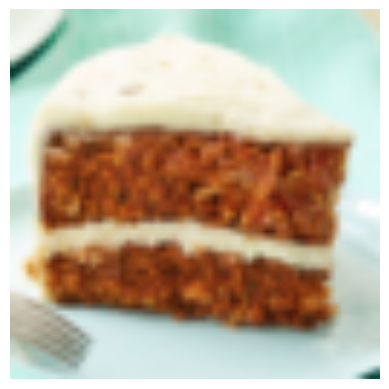

Model Generated: 


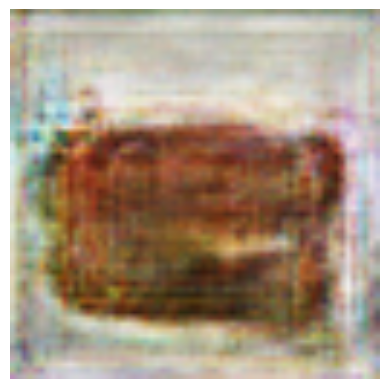

In [46]:
random_picture = augmented_dataset[52].to("cpu").unsqueeze(0)
best_init_vec_1 = find_best_initial_vector(gen, random_picture, 128, "./gifs/search2.gif", image_step=5)

### Większy dataset

In [79]:
class BigDataset(Dataset):
    def __init__(
            self, 
            data_path: str,
            target_size: int,
            device: str,
            transforms: v2.Compose
        ):
        super().__init__()

        self.device = device
        self.data_path = data_path
        self.transforms = transforms
        self.image_names = os.listdir(data_path)
    
    def __getitem__(self, idx):
        img = Image.open(f"{self.data_path}/{self.image_names[idx]}")
        transformed = self.transforms(img).to(self.device)
        return transformed
    
    def __len__(self):
        return len(self.image_names)
    
tf = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((64, 64)),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [81]:
big_dataset = BigDataset("./data/cats", 64, device, tf)

In [ ]:
gan_training(
    "cats", 
    big_dataset, 
    16, 
    device, 
    max_epochs=500,
    
    loss_logging_step=1, 
    image_print_step=1, 
    model_checkpoint_step=5, 
    input_vector_size=128, 

    discriminator_lr=0.00001,
    generator_lr=0.00002,
    generator_type="alternative"
)

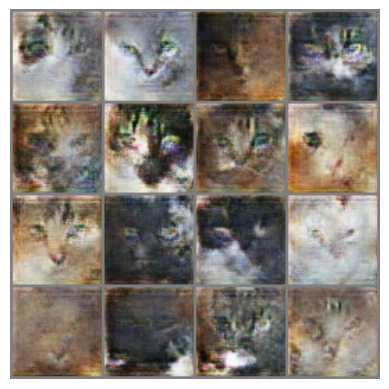

In [51]:
gen = load_generator("cats", 10, 128, "alternative")

with torch.no_grad():
    vec = torch.randn(16, 128)
    out = gen(vec)

show_image_batch(out, 4)